In [0]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.manifold import TSNE
import json

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Set to your own directory below. Data is converted to audio from http://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html
#I used emo_s01-01cfs, emo_s01-13cfs, emo_s01-23cfs, and emo_s01-31cfs, converted to csv then to mp3 for my particular visualization.
source_audio = '/content/gdrive/My Drive/Collab/eeg_emo_s01-01cfs_crop_toaudio.mp3' 
hop_length = 512
y, sr = librosa.load(source_audio)
onsets = librosa.onset.onset_detect(y=y, sr=sr, hop_length=hop_length)

Text(0.5, 1.0, 'Sound file with 1203 onsets plotted')

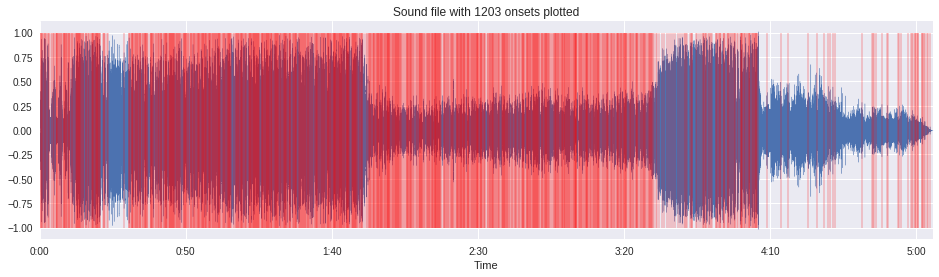

In [0]:
times = [hop_length * onset / sr for onset in onsets]

plt.figure(figsize=(16,4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.vlines(times, -1, 1, color='r', alpha=0.2, label='Onsets')
plt.title('Sound file with %d onsets plotted' % len(times))

In [0]:
def get_features(y, sr):
    y = y[0:sr]  # analyze just first second
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

In [0]:
# where to save our new clips to, broken into separate wave files.
path_save_intervals = '/content/gdrive/My Drive/Collab/output/'

# make new directory to save them
if not os.path.isdir(path_save_intervals):
    os.mkdir(path_save_intervals)

# grab each interval, extract a feature vector, and save the new clip to our above path
feature_vectors = []
for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ] * hop_length  # first sample of the interval
    idx_y2 = onsets[i+1] * hop_length  # last sample of the interval
    y_interval = y[idx_y1:idx_y2]
    features = get_features(y_interval, sr)   # get feature vector for the audio clip between y1 and y2
    file_path = '%s/onset_%d.wav' % (path_save_intervals, i)   # where to save our new audio clip
    feature_vectors.append({"file":file_path, "features":features})   # append to a feature vector
    librosa.output.write_wav(file_path, y_interval, sr)   # save to disk
    

In [0]:
# save results to this json file
tsne_path = "/content/gdrive/My Drive/Collab/audio-tsne-onsets.json"

# feature_vectors has both the features and file paths in it. let's pull out just the feature vectors
features_matrix = [f["features"] for f in feature_vectors]

# calculate a t-SNE and normalize it
model = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit_transform(features_matrix)
x_axis, y_axis = model[:,0], model[:,1] # normalize t-SNE
x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = [{"path":os.path.abspath(f['file']), "point":[float(x), float(y)]} for f, x, y in zip(feature_vectors, x_norm, y_norm)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved %s to disk!" % tsne_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1202 samples in 0.004s...
[t-SNE] Computed neighbors for 1202 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1202
[t-SNE] Computed conditional probabilities for sample 1202 / 1202
[t-SNE] Mean sigma: 0.103962
[t-SNE] Computed conditional probabilities in 0.086s
[t-SNE] Iteration 50: error = 70.7034149, gradient norm = 0.0646717 (50 iterations in 2.058s)
[t-SNE] Iteration 100: error = 68.1163330, gradient norm = 0.0478360 (50 iterations in 1.105s)
[t-SNE] Iteration 150: error = 68.0576096, gradient norm = 0.0289975 (50 iterations in 0.838s)
[t-SNE] Iteration 200: error = 68.0435944, gradient norm = 0.0288474 (50 iterations in 0.824s)
[t-SNE] Iteration 250: error = 68.0341568, gradient norm = 0.0435065 (50 iterations in 0.813s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.034157
[t-SNE] Iteration 300: error = 1.3254340, gradient norm = 0.0009554 (50 iterations in 1.546s)

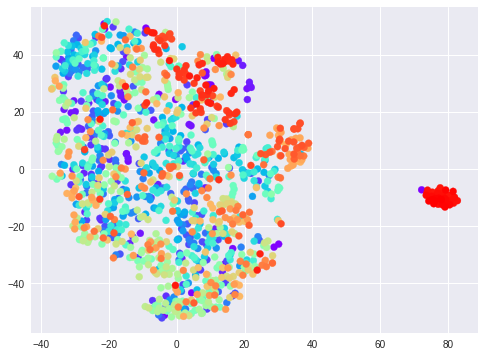

(0.0, 1.0, 0.0, 1.0)

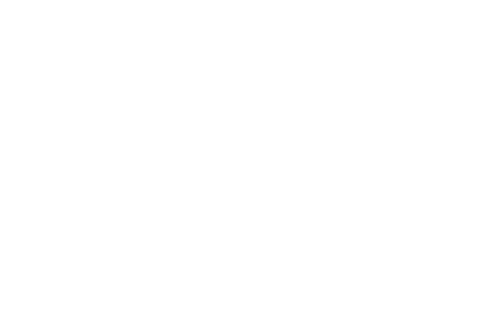

In [0]:

colors = cm.rainbow(np.linspace(0, 1, len(x_axis)))
plt.figure(figsize = (8,6))
plt.scatter(x_axis, y_axis, color=colors)
plt.show()
plt.axis('off')